In [1]:
import sys
sys.path.append('../')

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
import torch.distributions as D

import numpy as np
import pandas as pd
import os
import glob
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from data import *
from simple_models import *

eps = np.finfo(float).eps

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
use_cuda = True

if use_cuda:
    dtype = torch.cuda.FloatTensor
    device = torch.device("cuda")
    torch.cuda.set_device(0)
    print('GPU')
else:
    dtype = torch.FloatTensor
    device = torch.device("cpu")

GPU


In [3]:
 # Get train and test loaders for dataset
train_transforms = mnist_train_transforms()
test_transforms = mnist_test_transforms()
target_transforms = None

loader = Loader('MNISTC', '../data', True, 32, train_transforms, test_transforms, 
                target_transforms, use_cuda)
train_loader = loader.train_loader
test_loader = loader.test_loader

In [4]:
encoder = MNIST_Encoder(28 * 28, 64).type(dtype)
mi_estimator = MiEstimator(64, 64, 128).type(dtype)

E_optim = Adam(encoder.parameters(), lr=1e-3)
MI_optim = Adam(mi_estimator.parameters(), lr=1e-3)

In [7]:
num_epochs = 10
beta = 1.

loss_hist = []

encoder.train()
mi_estimator.train()

for epoch in range(num_epochs):
    print("Epoch: {}".format(epoch))
    batch_loss = 0.
    for ind, (xi, xj, _) in enumerate(train_loader):
        
        xi = xi.cuda() if use_cuda else xi
        xj = xj.cuda() if use_cuda else xj

        # Encoder forward
        p_xi_vi = encoder(xi)
        p_xj_vj = encoder(xj)

        # Sample
        zi = p_xi_vi.rsample()
        zj = p_xj_vj.rsample()

        # MI gradient
        mi_grad, mi_out = mi_estimator(zi, zj)
        mi_grad *= -1

        mi_estimator.zero_grad()
        mi_grad.backward(retain_graph=True)
        MI_optim.step()
        
        # Symmetric KL
        kl_1_2 = p_xi_vi.log_prob(zi) - p_xj_vj.log_prob(zi)
        kl_2_1 = p_xj_vj.log_prob(zj) - p_xi_vi.log_prob(zj)
        skl = (kl_1_2 + kl_2_1).mean() / 2.

        loss = mi_grad + beta * skl
        
        encoder.zero_grad()
        loss.backward()
        E_optim.step()

        batch_loss += (loss.item() / xi.size(0))
    
    loss_hist.append(batch_loss / (ind + 1))

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9


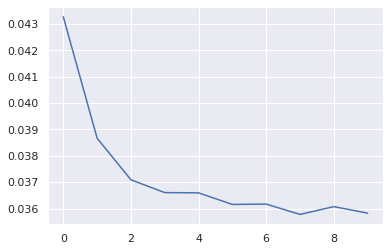

In [8]:
sns.set()
plt.plot(loss_hist)

### Possitive Negative pairs KL approach

In [ ]:
encoder = MNIST_Encoder(28 * 28, 64).type(dtype)
mi_estimator = MiEstimator(64, 64, 128).type(dtype)

E_optim = Adam(encoder.parameters(), lr=1e-3)
MI_optim = Adam(mi_estimator.parameters(), lr=1e-3)

In [ ]:
num_epochs = 10
beta = 1.

loss_hist = []
skl_hist = []
pnkl_hist = []

encoder.train()
mi_estimator.train()

for epoch in range(num_epochs):
    print("Epoch: {}".format(epoch))
    batch_loss = 0.
    batch_skl = 0.
    batch_pnkl = 0.
    for ind, (xi, xj, _) in enumerate(train_loader):
        
        xi = xi.cuda() if use_cuda else xi
        xj = xj.cuda() if use_cuda else xj

        # Encoder forward
        p_xi_vi = encoder(xi)
        p_xj_vj = encoder(xj)

        # Sample
        zi = p_xi_vi.rsample()
        zj = p_xj_vj.rsample()

        # MI gradient
        mi_grad, mi_out = mi_estimator(zi, zj)
        mi_grad *= -1

        mi_estimator.zero_grad()
        mi_grad.backward(retain_graph=True)
        MI_optim.step()
        
        # Symmetric KL
        kl_1_2 = p_xi_vi.log_prob(zi) - p_xj_vj.log_prob(zi)
        kl_2_1 = p_xj_vj.log_prob(zj) - p_xi_vi.log_prob(zj)
        skl = (kl_1_2 + kl_2_1).mean() / 2.
        
        
        # positive negative kl
        

        loss = mi_grad + beta * skl
        
        encoder.zero_grad()
        loss.backward()
        E_optim.step()

        batch_loss += (loss.item() / xi.size(0))
        batch_skl_loss += (skl.item() / xi.size(0))
        batch_pnkl += (pnkl.item() / xi.size(0))
    
    loss_hist.append(batch_loss / (ind + 1))
    skl_hist.append(batch_skl_loss / (ind + 1))
    pnkl_hist.append(batch_pnkl / (ind + 1))